In [1]:
import os
import torch
import numpy as np
import librosa
import soundfile as sf
import torch
import torch.nn as nn




In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

class RectifiedFlowModel(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
        )
        
    def forward(self, x, t):
        """
        x: (B, 1, n_mels, T)
        t: (B, 1, 1, 1) or broadcastable scalar
        """
        if t is None:
            raise ValueError("t must be provided for rectified flow model")

        # Make a constant time-channel with same H,W
        B, _, H, W = x.shape
        t_map = t.expand(B, 1, H, W)   # (B, 1, H, W)

        x_in = torch.cat([x, t_map], dim=1)  # (B, 2, H, W)
        return self.conv(x_in) 
    
model = RectifiedFlowModel(n_mels=128).to(DEVICE)

# Load weights
ckpt_path = "./models/rectified_flow_model_625_100.pth"
state_dict = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("Loaded weights from", ckpt_path)



Using device: cuda
Loaded weights from ./models/rectified_flow_model_625_100.pth


In [3]:
# Mel spec params (change as needed)
SR = 16000          # sample rate used for training
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 256

def audio_to_logmel(y, sr=SR):
    """Waveform -> log-mel spectrogram (n_mels, T)."""
    if sr != SR:
        y = librosa.resample(y, orig_sr=sr, target_sr=SR)
        sr = SR
    
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        power=2.0,
    )
    logmel = np.log1p(mel).astype(np.float32)  # simple log scaling
    return logmel, sr


def logmel_to_audio_gl(logmel, sr=SR, n_iter=64):
    """Log-mel spectrogram -> waveform using Griffin-Lim."""
    mel = np.expm1(logmel)  # invert log1p
    y = librosa.feature.inverse.mel_to_audio(
        mel,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_iter=64,
    )
    return y

def rectified_flow_sample(model, g_mel_tensor, n_steps=100):
    """
    g_mel_tensor: (B, 1, n_mels, T) at t=0
    Returns: x_1 approx (B, 1, n_mels, T) predicted piano mel
    """
    model.eval()
    x = g_mel_tensor.clone().to(DEVICE)  # (B, 1, n_mels, T)
    dt = 1.0 / n_steps

    with torch.no_grad():
        for i in range(n_steps):
            # use mid-point time for slightly nicer behaviour
            t_scalar = (i + 0.5) / n_steps
            t = torch.full((x.size(0), 1, 1, 1), t_scalar, device=DEVICE)
            v = model(x, t)      # (B, 1, n_mels, T)
            x = x + v * dt       # Euler step

    return x



In [4]:
!pip install noisereduce

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import noisereduce as nr

def denoise_audio_light(y, sr):
    # Use a short noise profile (0.25 sec)
    noise_len = min(int(0.25 * sr), len(y))
    noise_profile = y[:noise_len]

    y_denoised = nr.reduce_noise(
        y=y,
        y_noise=noise_profile,
        sr=sr,
        prop_decrease=0.35,  # light reduction
        stationary=True
    )
    return y_denoised


In [5]:
def chunk_logmel(logmel, chunk_frames=50, hop_frames=25):
    """Slice a logmel spectrogram along time with overlap"""
    chunks = []
    T = logmel.shape[1]
    for start in range(0, T - chunk_frames + 1, hop_frames):
        end = start + chunk_frames
        chunks.append(logmel[:, start:end])
    return chunks

def overlap_add(chunks):
    """Reconstruct time dimension using simple crossfade average"""
    n_mels, chunk_frames = chunks[0].shape
    total_frames = chunk_frames + (len(chunks) - 1) * (chunk_frames // 2)
    out = np.zeros((n_mels, total_frames))
    count = np.zeros((n_mels, total_frames))

    hop = chunk_frames // 2
    idx = 0
    for c in chunks:
        out[:, idx:idx+chunk_frames] += c
        count[:, idx:idx+chunk_frames] += 1
        idx += hop

    return out / np.maximum(count, 1e-8)


In [10]:
import os

output_dir = "/projectnb/ec523bn/projects/music_project/project/outputs2/pred_piano_try3"
os.makedirs(output_dir, exist_ok=True)

mse_list = []

for clip_id in range(1, 32):  # 1..31
    g_path = f"dataset/guitar/clip_{clip_id}.wav"
    p_path = f"dataset/piano/clip_{clip_id}.wav"

    if not os.path.exists(g_path):
        print(f"[{clip_id:02d}] Missing guitar file {g_path}, skipping.")
        continue

    # Load guitar audio and convert to log-mel 
    y_g, sr_g = librosa.load(g_path, sr=None, mono=True)
    g_logmel, _ = audio_to_logmel(y_g, sr=sr_g)   # (n_mels, T)

    # tensor shape: (B=1, C=1, n_mels, T)
    g_tensor = torch.from_numpy(g_logmel).unsqueeze(0).unsqueeze(0).to(DEVICE)

    # Run rectified flow sampler
    #pred_logmel_tensor = rectified_flow_sample(model, g_tensor, n_steps=100)
    #pred_logmel = pred_logmel_tensor.squeeze().cpu().numpy()  # (n_mels, T)

    # Run inference on short overlapping chunks 
    chunk_size = 50  # ~0.5 sec at 16000Hz mel settings
    hop = 25         # 50% overlap

    mel_chunks = chunk_logmel(g_logmel, chunk_frames=chunk_size, hop_frames=hop)

    pred_chunks = []
    model.eval()
    with torch.no_grad():
        for mel in mel_chunks:
            mel_tensor = torch.from_numpy(mel).unsqueeze(0).unsqueeze(0).to(DEVICE)
            pred_tensor = rectified_flow_sample(model, mel_tensor, n_steps=100)
            pred_chunks.append(pred_tensor.squeeze().cpu().numpy())

    # Reconstruct continuous mel spectrogram
    pred_logmel = overlap_add(pred_chunks)
    
    # Convert predicted log-mel back to audio 
    y_pred = logmel_to_audio_gl(pred_logmel, sr=SR)

    # Normalize just to be safe
    #y_pred = y_pred / (np.max(np.abs(y_pred)) + 1e-8)
    # Light Denoise
    y_pred = denoise_audio_light(y_pred, SR)

    # Normalize
    y_pred = y_pred / (np.max(np.abs(y_pred)) + 1e-8)

    out_path = f"outputs2/pred_piano_try3/clip_{clip_id}.wav"
    sf.write(out_path, y_pred, SR)
    print(f"[{clip_id:02d}] Saved predicted piano -> {out_path}")

    # compare to ground-truth piano in mel space 
    if os.path.exists(p_path):
        y_p, sr_p = librosa.load(p_path, sr=None, mono=True)
        p_logmel, _ = audio_to_logmel(y_p, sr=sr_p)

        # crop to min time dim in case of slight diff
        T_min = min(pred_logmel.shape[-1], p_logmel.shape[-1])
        mse = float(np.mean((pred_logmel[:, :T_min] - p_logmel[:, :T_min])**2))
        mse_list.append(mse)
        print(f"    MSE (log-mel) vs true piano: {mse:.6f}")

if mse_list:
    print("\nAverage log-mel MSE over clips:", np.mean(mse_list))


[01] Saved predicted piano -> outputs2/pred_piano_try3/clip_1.wav
    MSE (log-mel) vs true piano: 14.628335
[02] Saved predicted piano -> outputs2/pred_piano_try3/clip_2.wav
    MSE (log-mel) vs true piano: 18.456254
[03] Saved predicted piano -> outputs2/pred_piano_try3/clip_3.wav
    MSE (log-mel) vs true piano: 19.307365
[04] Saved predicted piano -> outputs2/pred_piano_try3/clip_4.wav
    MSE (log-mel) vs true piano: 18.530641
[05] Saved predicted piano -> outputs2/pred_piano_try3/clip_5.wav
    MSE (log-mel) vs true piano: 18.953978
[06] Saved predicted piano -> outputs2/pred_piano_try3/clip_6.wav
    MSE (log-mel) vs true piano: 18.647311
[07] Saved predicted piano -> outputs2/pred_piano_try3/clip_7.wav
    MSE (log-mel) vs true piano: 18.395800
[08] Saved predicted piano -> outputs2/pred_piano_try3/clip_8.wav
    MSE (log-mel) vs true piano: 19.145686
[09] Saved predicted piano -> outputs2/pred_piano_try3/clip_9.wav
    MSE (log-mel) vs true piano: 18.332142
[10] Saved predicte

File: clip_14.wav
Sample rate: 22050, Duration: 5.00s


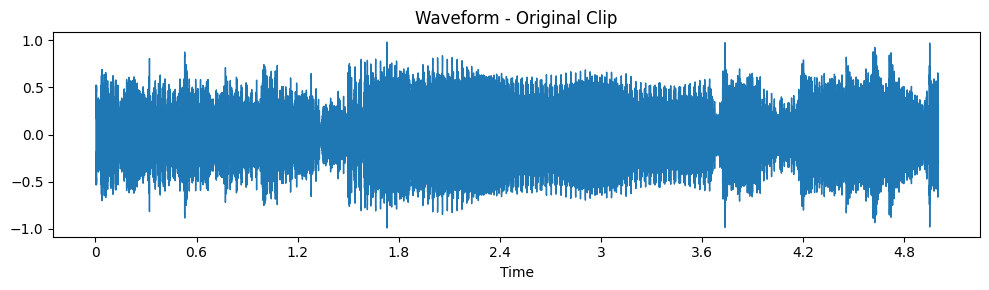

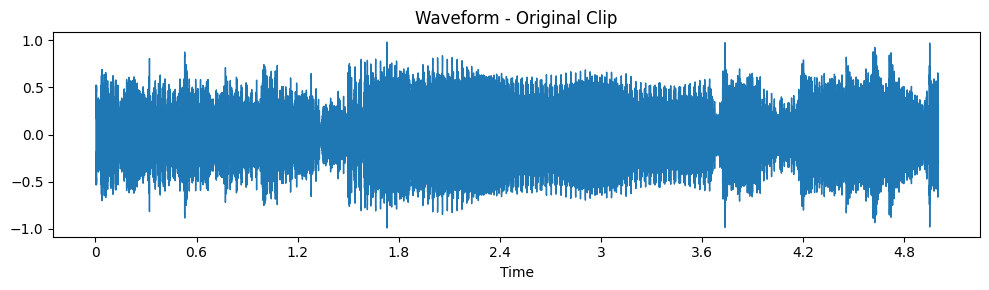

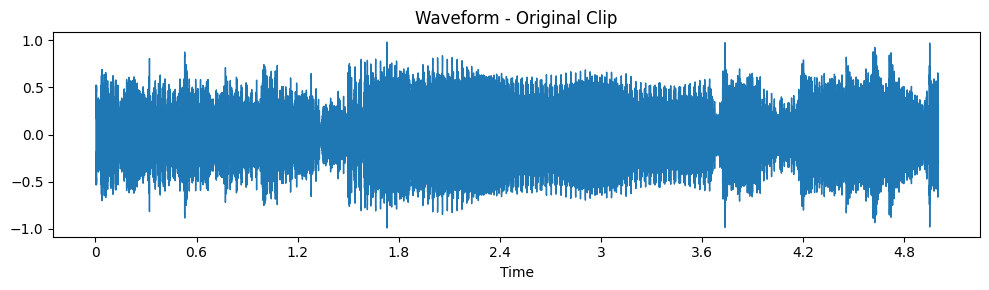

AttributeError: module 'matplotlib' has no attribute 'pyplot'

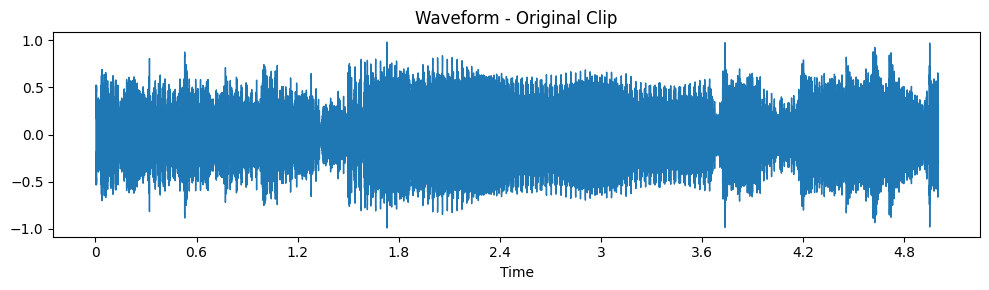

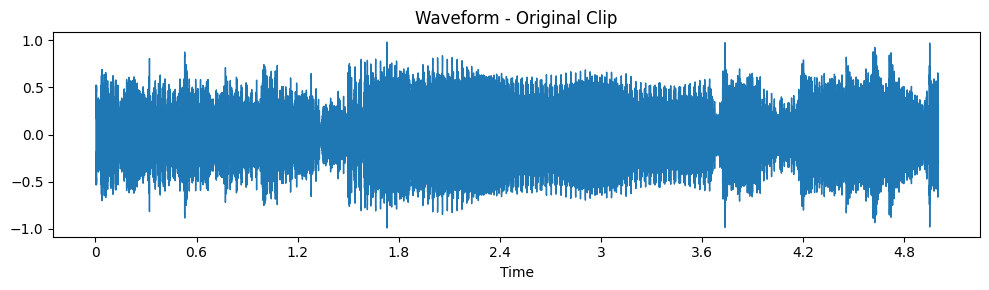

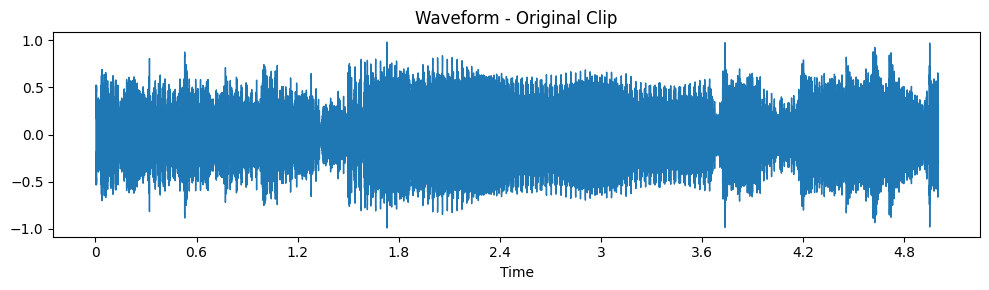

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
%matplotlib inline


def plot_mel_spectrogram(file_path, title="Audio"):
    # Load audio file
    y, sr = librosa.load(file_path, duration=5.0)
    
    print(f"File: {os.path.basename(file_path)}")
    print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f}s")

    # Waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {title}")
    plt.tight_layout()
    plt.show()

    # Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel-Spectrogram - {title}")
    plt.tight_layout()
    plt.show()


clip_id = 14
original_audio = f"dataset/guitar/clip_{clip_id}.wav"
predicted_audio = f"outputs2/pred_piano_try3/clip_{clip_id}.wav"

plot_mel_spectrogram(original_audio, title="Original Clip")
plot_mel_spectrogram(predicted_audio, title="Predicted Clip")


In [ ]:
from IPython.display import Audio, display
import librosa
import os

# preview clips
clip_id = 1  # change this to 1..31

g_path = f"dataset/guitar/clip_{clip_id}.wav"
p_true_path = f"dataset/piano/clip_{clip_id}.wav"
p_pred_path = f"outputs/pred_piano/clip_{clip_id}.wav"

print(f"Previewing clip_{clip_id} 🎵")
print("-" * 40)

def load_audio(path):
    if not os.path.exists(path):
        print(f"Missing file: {path}")
        return None, None
    y, sr = librosa.load(path, sr=None, mono=True)
    return y, sr

# Load all three (if they exist)
y_g, sr_g = load_audio(g_path)
y_p_true, sr_p_true = load_audio(p_true_path)
y_p_pred, sr_p_pred = load_audio(p_pred_path)

# Guitar (input)
if y_g is not None:
    print("Original guitar:")
    display(Audio(y_g, rate=sr_g))
else:
    print("No guitar audio found.")

print()

# Ground-truth piano
if y_p_true is not None:
    print("Ground-truth piano:")
    display(Audio(y_p_true, rate=sr_p_true))
else:
    print("No ground-truth piano audio found.")

print()

# Predicted piano
if y_p_pred is not None:
    print("Predicted piano (model output):")
    display(Audio(y_p_pred, rate=sr_p_pred))
else:
    print("No predicted piano audio found. Did you run the generation cell?")


Previewing clip_1 🎵
----------------------------------------
🎸 Original guitar:


In [9]:
import librosa
print(librosa.__file__)


/usr4/ec504rb/simonim/.local/lib/python3.10/site-packages/librosa/__init__.py
